# Week 2: Tackle Overfitting with Data Augmentation

Welcome to this assignment! As in the previous week, you will be using the famous `cats vs dogs` dataset to train a model that can classify images of dogs from images of cats. For this, you will create your own Convolutional Neural Network in Tensorflow and leverage Keras' image preprocessing utilities, more so this time around since Keras provides excellent support for augmenting image data.

You will also need to create the helper functions to move the images around the filesystem as you did last week, so if you need to refresh your memory with the `os` module be sure to take a look a the [docs](https://docs.python.org/3/library/os.html).

Let's get started!

In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
import warnings
warnings.filterwarnings('ignore')

Download the dataset from its original source by running the cell below. 

Note that the `zip` file that contains the images is unzipped under the `/tmp` directory.

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-05-04 05:03:39--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.118.8.139, 2600:1402:2000:193::e59, 2600:1402:2000:1bb::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.118.8.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   101MB/s    in 7.5s    

2022-05-04 05:03:46 (105 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [ ]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


In [ ]:
# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets
  
  Args:
    root_path (string) - the base directory path to create subdirectories from
  
  Returns:
    None
  """  

  ### START CODE HERE
  #create paths
  train_cat_path = os.path.join(root_path, 'training/cats') 
  train_dog_path = os.path.join(root_path, 'training/dogs')

  validation_cat_path = os.path.join(root_path, 'validation/cats')
  validation_dog_path = os.path.join(root_path, 'validation/dogs')
  
  #create dirs
  train_cat_dir = os.makedirs(train_cat_path)
  train_dog_dir = os.makedirs(train_dog_path)

  validation_cat_dir = os.makedirs(validation_cat_path)
  validation_dog_dir = os.makedirs(validation_dog_path)

  # HINT:
  # Use os.makedirs to create your directories with intermediate subdirectories
  # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter

  pass
  
  ### END CODE HERE

  
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs


In [ ]:
# GRADED FUNCTION: split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  """
  Splits the data into train and test sets
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (int): proportion of the dataset to be used for training
    
  Returns:
    None
  """
  ### START CODE HERE
  files = []

  for filename in os.listdir(SOURCE_DIR):
    file_path = os.path.join(SOURCE_DIR, filename)
    if os.path.getsize(file_path) > 0:
      files.append(filename)
    else:
      print(f"{filename} is zero length, so ignoring.")
  
  train_length = int(SPLIT_SIZE * len(files))

  shuffle_set = random.sample(files, len(files))
  train_set = shuffle_set[:train_length]
  validation_set = shuffle_set[train_length:]

  for filename in train_set:
    origin = os.path.join(SOURCE_DIR, filename)
    destination = os.path.join(TRAINING_DIR, filename)
    copyfile(origin, destination)

  for filename in validation_set:
    origin = os.path.join(SOURCE_DIR, filename)
    destination = os.path.join(VALIDATION_DIR, filename)
    copyfile(origin, destination)

  pass

  ### END CODE HERE


In [ ]:
# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


In [ ]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator


In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:
# GRADED FUNCTION: create_model
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  ### START CODE HERE

  model = tf.keras.models.Sequential([
      #first conv layer                                 
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPool2D(2,2),
      #second conv layer 
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPool2D(2,2),
      #third conv layer 
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPool2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(optimizer=RMSprop(learning_rate=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    
  ### END CODE HERE

  return model


In [ ]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
1125/1125 [==============================] - 175s 155ms/step - loss: 0.6286 - accuracy: 0.6382 - val_loss: 0.5330 - val_accuracy: 0.7360
Epoch 2/15
1125/1125 [==============================] - 174s 155ms/step - loss: 0.5722 - accuracy: 0.6962 - val_loss: 0.5151 - val_accuracy: 0.7432
Epoch 3/15
1125/1125 [==============================] - 173s 154ms/step - loss: 0.5432 - accuracy: 0.7229 - val_loss: 0.5207 - val_accuracy: 0.7296
Epoch 4/15
1125/1125 [==============================] - 173s 154ms/step - loss: 0.5202 - accuracy: 0.7396 - val_loss: 0.4553 - val_accuracy: 0.7956
Epoch 5/15
1125/1125 [==============================] - 173s 154ms/step - loss: 0.5078 - accuracy: 0.7509 - val_loss: 0.4366 - val_accuracy: 0.7972
Epoch 6/15
1125/1125 [==============================] - 173s 154ms/step - loss: 0.4973 - accuracy: 0.7610 - val_loss: 0.4588 - val_accuracy: 0.7808
Epoch 7/15
1125/1125 [==============================] - 174s 155ms/step - loss: 0.4822 - accuracy: 0.7673 - val_

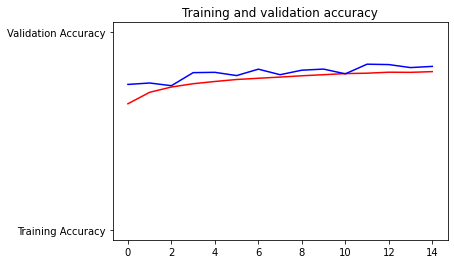

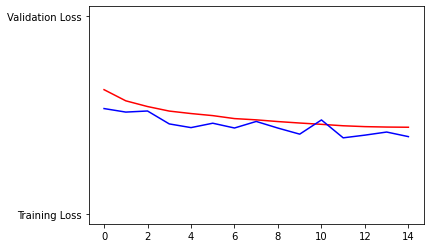

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
def download_history():
  import pickle
  from google.colab import files

  with open('history_augmented.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history_augmented.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>